In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/es/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

13

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(298, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,1.740,48.165,1.431,39.586,4.008,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.4,3855542,182,182,22694263_2
1,2,1.000,28.198,1.304,36.825,8.051,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.4,3855542,182,182,22694263_2
2,3,0.888,25.778,1.221,34.965,12.102,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.4,3855542,182,182,22694263_2
3,4,0.831,24.394,1.181,34.021,16.149,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.4,3855542,182,182,22694263_2
4,5,0.793,23.402,1.160,33.592,20.199,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.4,3855542,182,182,22694263_2


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694263_1,3.856,0.4,1.000e-04,256,2,98.330,0.673,1.078,24
22694263_10,3.856,0.3,1.000e-02,256,2,97.402,2.280,2.366,24
22694263_11,3.856,0.4,1.000e-02,256,2,98.672,2.280,2.363,20
22694263_12,3.856,0.3,1.000e-03,256,2,99.040,0.917,1.285,20
22694263_2,3.856,0.4,1.000e-04,256,2,96.868,0.688,1.077,19
22694263_3,3.856,0.2,1.000e-04,256,2,97.661,0.573,1.065,10
22694263_4,3.856,0.4,1.000e-02,256,2,99.569,2.287,2.375,23
22694263_5,3.856,0.4,1.000e-02,256,2,98.720,2.290,2.373,19
22694263_6,3.856,0.3,1.000e-03,256,2,98.185,0.909,1.250,24


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/es/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

13

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(130, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22694263_5,-62.681,disjoint,greedy,100,2.428,43.407,70.615,NaN
1,22694263_5,-60.850,disjoint,greedy,50,1.393,43.407,69.820,NaN
2,22694263_5,-86.528,disjoint,beam,100,7.789,43.407,80.966,NaN
3,22694263_5,-84.814,disjoint,beam,50,5.570,43.407,80.223,NaN
4,22694263_5,-50.499,sliding,greedy,50,32.264,43.407,65.327,uniform


In [9]:
evaluation.experiment_id.value_counts()

22694263_10    10
22694263_9     10
22694263_11    10
22694263_3     10
22694263_7     10
test           10
22694263_12    10
22694263_8     10
22694263_2     10
22694263_5     10
22694263_1     10
22694263_6     10
22694263_4     10
Name: experiment_id, dtype: int64

In [10]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(10)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
7,22694263_2,41.341,sliding,beam,50,253.573,43.407,25.462,uniform,3.856,0.4,1.000e-04,256,2,96.868,0.688,1.077,19
8,22694263_2,41.241,sliding,beam,50,253.407,43.407,25.505,triangle,3.856,0.4,1.000e-04,256,2,96.868,0.688,1.077,19
9,22694263_2,41.174,sliding,beam,50,253.709,43.407,25.535,bell,3.856,0.4,1.000e-04,256,2,96.868,0.688,1.077,19
4,22694263_1,40.983,sliding,greedy,50,34.642,43.407,25.618,uniform,3.856,0.4,1.000e-04,256,2,98.330,0.673,1.078,24
6,22694263_1,40.853,sliding,greedy,50,35.158,43.407,25.674,bell,3.856,0.4,1.000e-04,256,2,98.330,0.673,1.078,24
5,22694263_1,40.820,sliding,greedy,50,34.784,43.407,25.688,triangle,3.856,0.4,1.000e-04,256,2,98.330,0.673,1.078,24
3,22694263_2,40.063,disjoint,beam,50,5.626,43.407,26.017,NaN,3.856,0.4,1.000e-04,256,2,96.868,0.688,1.077,19
4,22694263_3,39.848,sliding,greedy,50,33.179,43.407,26.110,uniform,3.856,0.2,1.000e-04,256,2,97.661,0.573,1.065,10
5,22694263_3,39.808,sliding,greedy,50,33.119,43.407,26.128,triangle,3.856,0.2,1.000e-04,256,2,97.661,0.573,1.065,10
4,22694263_8,39.804,sliding,greedy,50,38.207,43.407,26.129,uniform,3.856,0.5,1.000e-04,256,2,100.887,0.748,1.125,22


<AxesSubplot:>

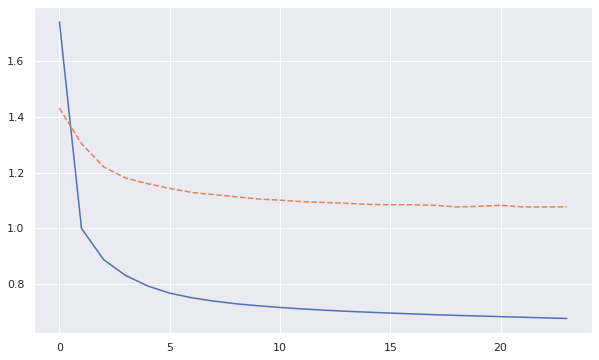

In [11]:
logs.query("experiment_id == '22694263_2'").train_loss.plot()
logs.query("experiment_id == '22694263_2'").dev_loss.plot(ls = "--")

In [12]:
results.query("experiment_id == '22694263_2'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                         sliding                   \
window_size        50              100             50                     
decoding          beam  greedy    beam  greedy    beam                    
weighting          NaN     NaN     NaN     NaN    bell triangle uniform   
experiment_id                                                             
22694263_2      40.063  28.648  18.678  35.979  41.174   41.241  41.341   

window                                  
window_size                             
decoding       greedy                   
weighting        bell triangle uniform  
experiment_id                           
22694263_2     39.329   39.336  39.443